# Описание проекта

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Собраны характеристики пробы нефти для скважин: качество нефти и объём её запасов по трем регионам. Характеристики для каждой скважины в регионе уже известны. 

Построена модель для предсказания объёма запасов в новых скважинах.
Выбраны скважины с самыми высокими оценками значений.

Определены регионы с максимальной суммарной прибылью отобранных скважин.

Построена модель для определения региона, где добыча принесёт наибольшую прибыль. 

Проанализирована возможная прибыль и риски техникой `Bootstrap`.

### Задачи проекта
Разработка модели, предсказывающей коэффициент восстановления золота из золотосодержащей руды. 

* При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 5%. Среди них выбирают регион с наибольшей средней прибылью.

### Ключевые слова и навыки

`A/B-тестирование, Bootstrap, data science, machine learning, ML, Python, SQL, Git, Pandas, Numpy, Matplotlib, seaborn, Sklearn, Tableau, Spark, Hadoop, R, sci-py, Research, Kaggle, Algorithms, PyTorch, TensorFlow, CatBoost, xgboost,  Support vector machines, градиентный бустинг, нелинейная оптимизация, кластеризация, random forest, descision trees,  regression,  Reinforcement Learning, OpenCV, PIL`

### Описание данных

* `id` — уникальный идентификатор скважины;
* `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей)

# Содержание <a name="title"></a>

[Импорт библиотек и задание констант](#import)
1. [Загрузка и подготовка данных](#1)

    1.1 [Подготовка региона alpha](#1.1)
    
    1.2 [Подготовка региона beta](#1.2)
    
    1.3 [Подготовка региона gamma](#1.3)
    
 
2. [Обучение и проверка модели](#2)

    2.1 [Обучение и проверка региона alpha](#2.1)
    
    2.2 [Обучение и проверка региона beta](#2.2)
    
    2.3 [Обучение и проверка региона gamma](#2.3)
    
    
3. [Подготовка к расчёту прибыли](#3)


4. [Расчёт прибыли по выбранным скважинам](#4)


5. [Расчёт рисков и прибыли для каждого региона](#5)

# Импорт библиотек и задание констант <a name="import"></a>

In [1]:
import pandas as pd
from IPython.display import display
import inspect
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

RNG = 123 # константа для random_state

[Содержание](#title)

# 1. Загрузка и подготовка данных <a name="1"></a>

Загрузим данные геолокации и зададим названия для регионов **alpha, beta, gamma**

In [2]:
alpha = pd.read_csv('/datasets/geo_data_0.csv')
beta = pd.read_csv('/datasets/geo_data_1.csv')
gamma = pd.read_csv('/datasets/geo_data_2.csv')

Создадим классы и функции необходимые для удобного ознакомления с информацией

In [3]:
class Explorer:
    class show(object):
        template = """<div style="float: left; padding: 10px;">
        <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
        </div>"""

        def __init__(self, *args):
            self.args = args
    
        def _repr_html_(self):
            return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
        
def review(data):
    return pd.concat([data.head(), data.tail()], keys=['head', 'tail'])
    
explorer = Explorer()

[Содержание](#title)

## 1.1 Подготовка региона alpha <a name="1.1"></a>

Рассмотрим регион **alpha**

In [4]:
display(explorer.show('review(alpha)', 'alpha.describe()'))
display(alpha.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропусков не обнаружено, данные корректного формата. При визуальном осмотре выбросы не обнаружены.

Проверим наличие полных дубликатов и уникальных значений в столбцах.

In [5]:
print('В датасете {} полных дубликатов'.format(alpha.duplicated().sum()))
alpha.nunique()

В датасете 0 полных дубликатов


id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Прослеживаются повторения значений идентификатора скважины. Это могло произойти из-за повторного исследования скважины или из-за ошибок при формировании датасета. Общий объём повторений крайне мал, он слабо повлияет на результат модели, поэтому оставим данные в первозданном виде.

[Содержание](#title)

## 1.2 Подготовка региона beta <a name="1.2"></a>

Рассмотрим регион **beta**

In [6]:
display(explorer.show('review(beta)', 'beta.describe()'))
display(beta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропусков не обнаружено, данные корректного формата. При визуальном осмотре выбросы не обнаружены, но заменты повторы в значениях объёма запаса.

Проверим наличие полных дубликатов и уникальных значений в столбцах.

In [7]:
print('В датасете {} полных дубликатов'.format(beta.duplicated().sum()))
beta.nunique()

В датасете 0 полных дубликатов


id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

Полных дубликатов не наблюдается.

Объёмы продукта в скавижине имеют **всего 12 уникальных значений**. Данные могли быть испорчены или получены некорректным способом, необходимо связаться со специалистом. Продолжим работу с данным датасетом, однако все выводы поставленные по нему **будем подвергать сомнению**. Повторения идентификатора скважины будем считать несущественными.

[Содержание](#title)

## 1.3 Подготовка региона gamma <a name="1.3"></a>

Рассмотрим регион **gamma**

In [8]:
display(explorer.show('review(gamma)', 'gamma.describe()'))
display(gamma.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропусков не обнаружено, данные корректного формата. При визуальном осмотре выбросы не обнаружены.

Проверим наличие полных дубликатов и уникальных значений в столбцах.

In [9]:
print('В датасете {} полных дубликатов'.format(gamma.duplicated().sum()))
gamma.nunique()

В датасете 0 полных дубликатов


id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Прослеживаются повторения значений идентификатора скважины. Это могло произойти из-за повторного исследования скважины или из-за ошибок при формировании датасета. Общий объём повторений крайне мал, он слабо повлияет на результат модели, поэтому оставим данные в первозданном виде.

[Содержание](#title)

# 2. Обучение и проверка модели <a name="2"></a>

Напишем функцию для разбития данных.

In [10]:
def df_split(data, features_drop, target, test_size, random_state):
    feature = data.drop(features_drop, axis=1)
    target = data[target]
    x_train, x_test, y_train, y_test  = train_test_split(feature, target, test_size=test_size, random_state = random_state)
    return x_train, x_test, y_train, y_test

[Содержание](#title)

## 2.1 Обучение и проверка региона alpha <a name="2.1"></a>

### 2.1.1 Разбитие данных на обучающуюся и валидационную выборку

Воспользуемся функцией **df_split** для создания выборок. Из признаков удалим столбец **id**, так как он не несёт полезной нагрузки и может негативно повлиять на результаты обучения.

In [11]:
features_train, features_valid, target_train, target_valid = df_split(alpha, ['id', 'product'], 'product', 0.25, RNG)
print(f'Размеры обучающих выборок {features_train.shape} и {target_train.shape}')
print(f'Размеры валидационных выборок {features_valid.shape} и {target_valid.shape}')

Размеры обучающих выборок (75000, 3) и (75000,)
Размеры валидационных выборок (25000, 3) и (25000,)


### 2.1.2 Обучение модели и предсказания для региона alpha

Обучим модель на основе линейной регрессии

In [12]:
model = LinearRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

Сравним правильные ответы и предсказания на валидационной выборке

In [13]:
alpha_predict = pd.DataFrame(target_valid)
alpha_predict['predict'] = predicted_valid
review(alpha_predict)

product     predict
head 42083  145.825972  123.284256
     71825  134.020212   75.838240
     99535   88.905826   55.526760
     47879   19.508226   86.673045
     36734  108.713468  109.909327
tail 56405   80.100250   89.708779
     50954   47.345664   55.672078
     99121  176.382705  139.042911
     4170   140.334745   96.867927
     18144  117.324049   54.714331

Выведим график пересечения предсказаний с правильными ответами

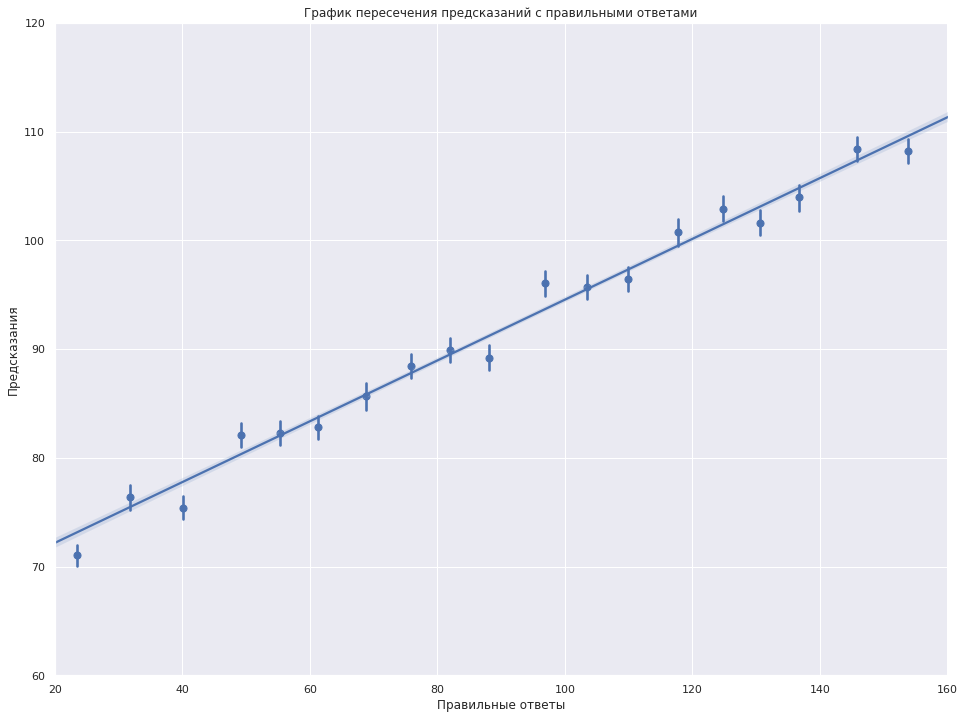

In [14]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(16,12))
ax = sns.regplot(x="product", y="predict", data = alpha_predict, x_bins=20)
plt.title("График пересечения предсказаний с правильными ответами")
ax.set_xlabel('Правильные ответы')
ax.set_ylabel('Предсказания')
ax.set(ylim=(60, 120))
ax.set(xlim=(20, 160))
plt.show()

Линия регрессии имеет положительную зависимость, однако является слишком пологой, поэтому предсказанные значения определяются с повышенной погрещностью на предельных значениях.

### 2.1.3 Расчёт среднего запаса и RSME

Произведем расчёт среднего

In [15]:
alpha_real_mean_product = alpha_predict['product'].mean()
alpha_predicted_mean_product = alpha_predict['predict'].mean()
print('Реальный средний объём запаса', alpha_real_mean_product)
print('Предсказанный средний объём запаса', alpha_predicted_mean_product)

Реальный средний объём запаса 92.85062391123445
Предсказанный средний объём запаса 92.54936189116309


Произведем расчёт RSME

In [16]:
mse = mean_squared_error(target_valid, predicted_valid)
rmse = np.sqrt(mse)
print('Значение mse равно', mse)
print('Значение rmse равно', rmse)

Значение mse равно 1417.3615751967832
Значение rmse равно 37.64786282376176


Корень из средней квадратичной ошибки составил 37 тыс. баррелей

**Вывод**

* Модель некорректно определяет значения на предельных значениях
* Предсказанный средний объём равен запасов равен 92,5 тыс. баррелей нефти, что близко к реальным значениям
* Значение RMSE равно 37.6 тыс. баррелей нефти

[Содержание](#title)

## 2.2 Обучение и проверка региона beta <a name="2.2"></a>

### 2.2.1 Разбитие данных на обучающуюся и валидационную выборку

Воспользуемся функцией **df_split** для создания выборок. Из признаков удалим столбец **id**, так как он не несёт полезной нагрузки и может негативно повлиять на результаты обучения.

In [17]:
features_train, features_valid, target_train, target_valid = df_split(beta, ['id', 'product'], 'product', 0.25, RNG)
print(f'Размеры обучающих выборок {features_train.shape} и {target_train.shape}')
print(f'Размеры валидационных выборок {features_valid.shape} и {target_valid.shape}')

Размеры обучающих выборок (75000, 3) и (75000,)
Размеры валидационных выборок (25000, 3) и (25000,)


### 2.2.2 Обучение модели и предсказания для региона beta

Обучим модель на основе линейной регрессии

In [18]:
model = LinearRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

Сравним правильные ответы и предсказания на валидационной выборке

In [19]:
beta_predict = pd.DataFrame(target_valid)
beta_predict['predict'] = predicted_valid
review(beta_predict)

product     predict
head 42083   57.085625   56.056314
     71825   80.859783   81.589811
     99535   53.906522   54.461926
     47879  107.813044  108.660979
     36734   53.906522   54.479416
tail 56405   30.132364   28.805734
     50954  110.992147  110.025164
     99121    3.179103    3.278982
     4170    53.906522   53.705839
     18144  134.766305  135.021879

Выведим график пересечения предсказаний с правильными ответами

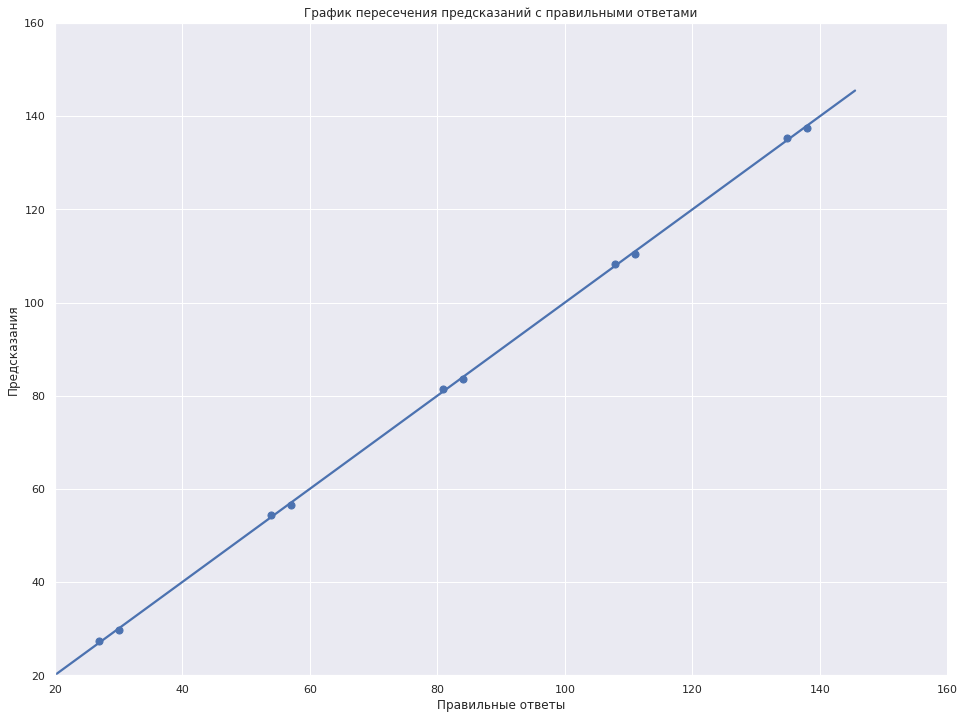

In [20]:
fig = plt.figure(figsize=(16,12))
ax = sns.regplot(x="product", y="predict", data = beta_predict, x_bins=20)
plt.title("График пересечения предсказаний с правильными ответами")
ax.set_xlabel('Правильные ответы')
ax.set_ylabel('Предсказания')
ax.set(ylim=(20, 160))
ax.set(xlim=(20, 160))
plt.show()

Линия регрессии имеет положительную зависимость, а качество предсказания приближено к идеальному. Тем не менее входные данные региона **beta** имеют низкое качество, делать выводы по данному региону не рекомендуется.

### 2.2.3 Расчёт среднего запаса и RSME

Произведем расчёт среднего

In [21]:
beta_real_mean_product = beta_predict['product'].mean()
beta_predicted_mean_product = beta_predict['predict'].mean()
print('Реальный средний объём запаса', beta_real_mean_product)
print('Предсказанный средний объём запаса', beta_predicted_mean_product)

Реальный средний объём запаса 69.27371236077902
Предсказанный средний объём запаса 69.28001860653976


Произведем расчёт RSME

In [22]:
mse = mean_squared_error(target_valid, predicted_valid)
rmse = np.sqrt(mse)
print('Значение mse равно', mse)
print('Значение rmse равно', rmse)

Значение mse равно 0.8017661964648802
Значение rmse равно 0.8954139804944304


Корень из средней квадратичной ошибки составил 0,89 тыс. баррелей

**Вывод**

* Модель очень качественно определяет объёмы запаса
* Предсказанный средний объём равен запасов равен 69,3 тыс. баррелей нефти, что близко к реальным значениям
* Значение RMSE крайне мало и равно 0,89 тыс. баррелей нефти
* Полученные выводы необходимо ставить под сомнение, так как входные данные с высокой вероятностью недостоверны

[Содержание](#title)

## 2.3 Обучение и проверка региона gamma <a name="2.3"></a>

### 2.3.1 Разбитие данных на обучающуюся и валидационную выборку

Воспользуемся функцией **df_split** для создания выборок. Из признаков удалим столбец **id**, так как он не несёт полезной нагрузки и может негативно повлиять на результаты обучения.

In [23]:
features_train, features_valid, target_train, target_valid = df_split(gamma, ['id', 'product'], 'product', 0.25, RNG)
print(f'Размеры обучающих выборок {features_train.shape} и {target_train.shape}')
print(f'Размеры валидационных выборок {features_valid.shape} и {target_valid.shape}')

Размеры обучающих выборок (75000, 3) и (75000,)
Размеры валидационных выборок (25000, 3) и (25000,)


### 2.3.2 Обучение модели и предсказания для региона gamma

Обучим модель на основе линейной регрессии

In [24]:
model = LinearRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

Сравним правильные ответы и предсказания на валидационной выборке

In [25]:
gamma_predict = pd.DataFrame(target_valid)
gamma_predict['predict'] = predicted_valid
review(gamma_predict)

product     predict
head 42083  147.451978   94.075161
     71825  128.711794  122.604414
     99535  106.628185   80.055039
     47879  128.787131  100.175906
     36734  159.328488   89.804044
tail 56405  114.783531   92.274315
     50954   48.814291   93.406866
     99121  152.196856   67.803679
     4170   137.501887   84.156844
     18144  125.854138  127.484202

Выведим график пересечения предсказаний с правильными ответами

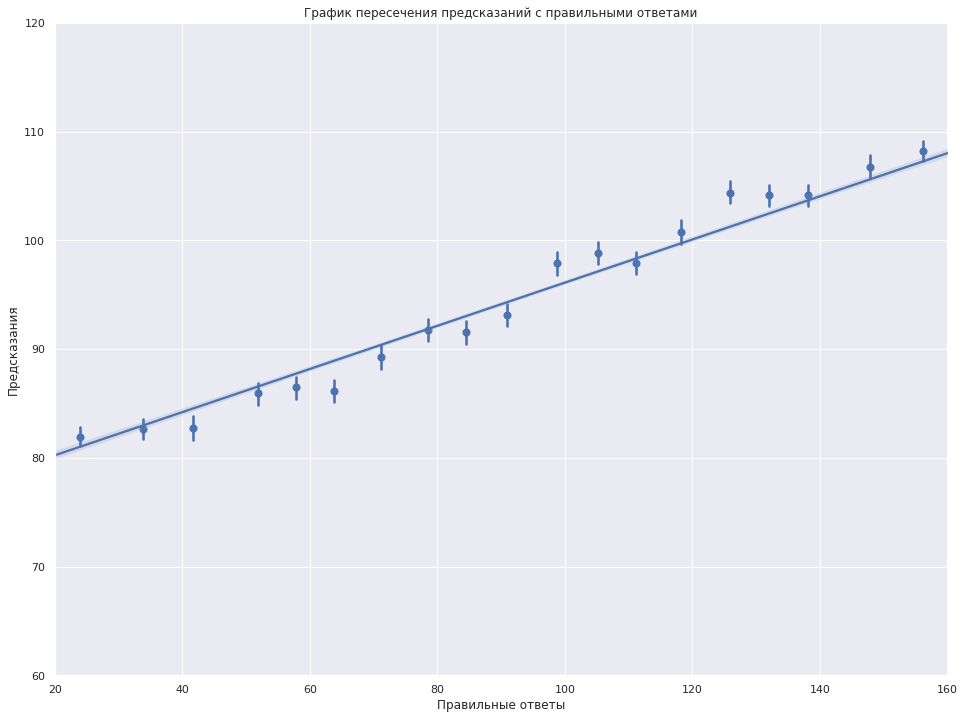

In [26]:
fig = plt.figure(figsize=(16,12))
ax = sns.regplot(x="product", y="predict", data = gamma_predict, x_bins=20)
plt.title("График пересечения предсказаний с правильными ответами")
ax.set_xlabel('Правильные ответы')
ax.set_ylabel('Предсказания')
ax.set(ylim=(60, 120))
ax.set(xlim=(20, 160))
plt.show()

Линия регрессии имеет положительную зависимость, однако является слишком пологой, поэтому предсказанные значения имеют очень низкую точность.

### 2.3.3 Расчёт среднего запаса и RSME

Произведем расчёт среднего

In [27]:
gamma_real_mean_product = gamma_predict['product'].mean()
gamma_predicted_mean_product = gamma_predict['predict'].mean()
print('Реальный средний объём запаса', gamma_real_mean_product)
print('Предсказанный средний объём запаса', gamma_predicted_mean_product)

Реальный средний объём запаса 94.87348818660215
Предсказанный средний объём запаса 95.09859933591373


Произведем расчёт RSME

In [28]:
mse = mean_squared_error(target_valid, predicted_valid)
rmse = np.sqrt(mse)
print('Значение mse равно', mse)
print('Значение rmse равно', rmse)

Значение mse равно 1610.2587969766078
Значение rmse равно 40.12803006598514


Корень из средней квадратичной ошибки составил 0,89 тыс. баррелей

**Вывод**

* Модель некорректно определяет значения объёмов запаса
* Предсказанный средний объём равен запасов равен 95,1 тыс. баррелей нефти, что близко к реальным значениям
* Значение RMSE равно 40.1 тыс. баррелей нефти

[Содержание](#title)

## 2.4 Вывод

Полученные модели, кроме региона **beta**, малопригодны для определения запасов нефти и несут высокие риски. Для повышения качества можно использовать другие методы построения модели и накопить более обширную базу данных.

# 3. Подготовка к расчёту прибыли <a name="3"></a>

Сохраним значения переменных

In [29]:
BUDGET = 10**7
MAX_RESEARCH = 500
WELL_RESEARCH = 200
PRICE_PER_BARREL = 450
print(f'Общий бюджет равен {BUDGET} тыс. рублей')
print(f'При разведке исследуют {MAX_RESEARCH} скважин')
print(f'Из которых выбирают {WELL_RESEARCH}  самых прибыльных скважин')
print(f'Стоимость тысячи баррелей нефти равна {PRICE_PER_BARREL} тыс. рублей')

Общий бюджет равен 10000000 тыс. рублей
При разведке исследуют 500 скважин
Из которых выбирают 200  самых прибыльных скважин
Стоимость тысячи баррелей нефти равна 450 тыс. рублей


## 3.1 Рассчёт достаточного объём сырья для безубыточной разработки новой скважины

Для расчёта поделим общий бюджет на количество разрабатываемых скважин

In [30]:
well_drilling_price = BUDGET / WELL_RESEARCH
print(f'Точка безубыточности для разработки скважины составляет {well_drilling_price} тыс. рублей')
well_reserves = well_drilling_price / PRICE_PER_BARREL
print('Минимальное количество запасов нефти в скважине для получения прибыли составляет {:.2f} тыс. баррелей'.format(well_reserves))

Точка безубыточности для разработки скважины составляет 50000.0 тыс. рублей
Минимальное количество запасов нефти в скважине для получения прибыли составляет 111.11 тыс. баррелей


Сравним полученный объём сырья со средним запасом в каждом регионе

In [31]:
data = {'alpha_mean': [alpha_real_mean_product],
        'beta_mean': [beta_real_mean_product],
        'gamma_mean': [gamma_real_mean_product],
        'well_reserves': [well_reserves]}
research = pd.DataFrame(data=data)
research

,alpha_mean,beta_mean,gamma_mean,well_reserves
0,92.850624,69.273712,94.873488,111.111111


## 3.2 Вывод

* Точка безубыточности для разработки скважины составляет 50000.0 тыс. рублей;
* Минимальное количество запасов нефти в скважине для получения прибыли составляет 111.1 тыс. баррелей;
* Средние запасы нефти во всех регионах существенно ниже требуемого минимального количества запасов, это значит, что ошибки при выборе скважин приведут к финансовым потерям.

[Содержание](#title)

# 4. Расчёт прибыли по выбранным скважинам<a name="4"></a>

Произведем расчёт максимально возможной прибыли выбранных скважин по предсказаниям модели

In [32]:
alpha_sort = alpha_predict.sort_values('predict', ascending=False).reset_index()[0:WELL_RESEARCH]
beta_sort = beta_predict.sort_values('predict', ascending=False).reset_index()[0:WELL_RESEARCH]
gamma_sort = gamma_predict.sort_values('predict', ascending=False).reset_index()[0:WELL_RESEARCH]

alpha_sort['profit, thousand rubles'] = alpha_sort['product'] * PRICE_PER_BARREL - well_drilling_price

beta_sort['profit, thousand rubles'] = beta_sort['product'] * PRICE_PER_BARREL - well_drilling_price

gamma_sort['profit, thousand rubles'] = gamma_sort['product'] * PRICE_PER_BARREL - well_drilling_price


gross_profit_table = pd.DataFrame({'profit, thousand rubles': [round(alpha_sort['profit, thousand rubles'].sum()),
                                                       round(beta_sort['profit, thousand rubles'].sum()),
                                                       round(gamma_sort['profit, thousand rubles'].sum())],
                                   'region': ['alpha', 'beta', 'gamma']}).set_index('region')


display(explorer.show('review(alpha_sort)', 'review(beta_sort)'))
display(explorer.show('review(gamma_sort)', 'gross_profit_table'))

print('Убыточных скважин alpha', len(alpha_sort.query('product < 111.12')))
print('Убыточных скважин beta', len(beta_sort.query('product < 111.12')))
print('Убыточных скважин gamma', len(gamma_sort.query('product < 111.12')))

Убыточных скважин alpha 8
Убыточных скважин beta 0
Убыточных скважин gamma 32


**Вывод**

Полученные результаты показывают самую высокую валовую прибыль в регионе **alpha**. Регион **beta** показывает положительную валовую прибыль, однако качество данных вызывает сомнение. В регионе **gamma** зафиксирована положительная валовая прибыль, но наблюдается высокое значение (больше 10%) убыточных скважин.

[Содержание](#title)

# 5. Расчёт рисков и прибыли для каждого региона <a name="5"></a>

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, 95%-й доверительный интервал и риск убытков.  

In [33]:
# функция для расчета прибыли по 200 самым высокодоходным скважинам, по результатам предсказаний
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return selected.sum()*PRICE_PER_BARREL - well_drilling_price*count

state = np.random.RandomState(RNG)

# формируем массивы данных по каждому региону
values_alpha = []
values_beta = []
values_gamma = []

for i in range(1000):
    
    # формируем выборки для 500 разведок региона
    target_subsample = alpha_predict['product'].sample(n=MAX_RESEARCH, replace=True, random_state=state)
    probs_subsample = alpha_predict['predict'][target_subsample.index]
    # считаем валовую прибыль по 200 лучшим скважинам после разведки
    values_alpha.append(revenue(target_subsample, probs_subsample, WELL_RESEARCH))
    
    #повторяем для других регионов
    target_subsample = beta_predict['product'].sample(n=MAX_RESEARCH, replace=True, random_state=state)
    probs_subsample = beta_predict['predict'][target_subsample.index]
    values_beta.append(revenue(target_subsample, probs_subsample, WELL_RESEARCH))
    
    target_subsample = gamma_predict['product'].sample(n=MAX_RESEARCH, replace=True, random_state=state)
    probs_subsample = gamma_predict['predict'][target_subsample.index]
    values_gamma.append(revenue(target_subsample, probs_subsample, WELL_RESEARCH))


values_alpha = pd.Series(values_alpha)
values_beta = pd.Series(values_beta)
values_gamma = pd.Series(values_gamma)

gross_profit_table = pd.DataFrame({'mean_gross_profit, thousand rubles': [values_alpha.mean(),
                                                       values_beta.mean(),
                                                       values_gamma.mean()],
                                   'region': ['alpha', 'beta', 'gamma'],
                                  'probability_of_loss': [(len(values_alpha[values_alpha<0])/len(values_alpha)),
                                                         (len(values_beta[values_beta<0])/len(values_beta)),
                                                         (len(values_gamma[values_gamma<0])/len(values_gamma))],
                                  'min_confidence_interval_of_95%': [int((st.t.interval(0.95, len(values_alpha)-1,
                                                                                        values_alpha.mean(), values_alpha.sem())[0])),
                                                                    int((st.t.interval(0.95, len(values_beta)-1,
                                                                                       values_beta.mean(), values_beta.sem())[0])),
                                                                    int((st.t.interval(0.95, len(values_gamma)-1,
                                                                                       values_gamma.mean(), values_gamma.sem())[0]))],
                                  'max_confidence_interval_of_95%': [int((st.t.interval(0.95, len(values_alpha)-1,
                                                                                        values_alpha.mean(), values_alpha.sem())[1])),
                                                                    int((st.t.interval(0.95, len(values_beta)-1,
                                                                                       values_beta.mean(), values_beta.sem())[1])),
                                                                    int((st.t.interval(0.95, len(values_gamma)-1,
                                                                                       values_gamma.mean(), values_gamma.sem())[1]))]}).\
set_index('region')

gross_profit_table.style\
.highlight_max(['mean_gross_profit, thousand rubles','min_confidence_interval_of_95%', 'max_confidence_interval_of_95%']
               ,color='lightgreen', axis = 0)\
.highlight_min(['probability_of_loss'],color='lightgreen', axis = 0)\
.highlight_min(['mean_gross_profit, thousand rubles','min_confidence_interval_of_95%', 'max_confidence_interval_of_95%']
               ,color='red', axis = 0)\
.highlight_max(['probability_of_loss'],color='red', axis = 0)

,"mean_gross_profit, thousand rubles",probability_of_loss,min_confidence_interval_of_95%,max_confidence_interval_of_95%
region,,,,
alpha,505101,0.036,487977,522223
beta,534873,0.007,521686,548059
gamma,372805,0.091,355419,390191


**Вывод**

* Наилучшие показатели по всем пунктам обеспечивает регион **beta**, но входные данные должны быть перепроверены. Добыча в данный момент не рекомендована;
* Худшие показатели по всем пунктам в регионе **gamma**, разработка в данном регионе слишком рискована. Риск убытков составляет более 9%;
* Приемлимые показатели обеспечивает регион **alpha**, с вероятностью 95% валовая прибыль будет в интервале от 488 млн. рублей до 522 млн. рублей. Входные данные по данному региону с высокой долей вероятности реальны.

[Содержание](#title)